## Comaprison of different Variational Methods 

In this notebook, we evaluate the performance of different methods. It compares the methods descripbed in 

* https://arxiv.org/pdf/1502.05336.pdf (Probabilistic Backpropagation for Scalable
Learning of Bayesian Neural Networks)
* https://arxiv.org/abs/1506.02142 (Gal)

* No Just Backprob:        4.539 +- 0.00288   (Lobato and Gal report the same error)
* MC-Droput:               4.36  ±0.04       (Gal)
* Probabalistic Backprob:  4.73  ±0.01  (Lobato and Gal)

Lobato and Gal trained for 40 epochs. 
Trained for 40 Epochs.

Hyperparameter Tuning:

BP and VI have several hyperparameters that have to be optimally adjusted to the data. These are learning rate and momentum in BP and VI and weight decay in BP. We select these hyperparameter values by maximizing the predictive performance of each method on a validation set with 20% of the training data.

In [32]:
print("Dense Rep", makeStats(accs_denserep_10))
print("Dense Flipout", makeStats(accs_denseflip_10))
print("MC-Dropout", makeStats(accs_dense_mc))
print("Baseline", makeStats(accs_noreg))

Dense Rep (4.5098184906806456, 0.01785685253714442)
Dense Flipout (4.490830526654179, 0.02635080635174702)
MC-Dropout (4.525929202670209, 0.02718851524701489)
Baseline (4.4695594706087896, 0.018948851765644762)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190424
TF  Version 2.0.0-alpha0


Loading the Data Set

In [2]:
import wget
import os
if not os.path.isfile('CASP.csv'):
    wget.download("https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv")
D = np.loadtxt('CASP.csv', skiprows=1,delimiter=',')
y = D[:,0]
X = D[:,1:10]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X))
X = scaler.transform(X)
X = np.asarray(X, np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X = X_train
y = y_train
X.shape, y.shape, y_train.shape, y_test.shape, X.min(), X.max()


StandardScaler(copy=True, with_mean=True, with_std=True)


((41157, 9), (41157,), (41157,), (4573,), -3.337702, 50.907627)

### Global Settings

In [3]:
sgd = tf.keras.optimizers.SGD(lr=.01, momentum=0.9, nesterov=True)
epochs = 50
bs = 32
loops = 10

In [34]:
# 
from sklearn.model_selection import train_test_split
def check_performance(build_model, X, y, mc_loops=-1):
    accs = np.zeros((loops))
    hists = list()
    for r in range(loops):  
        model = build_model()  
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        X = X_train
        y = y_train
        hist = model.fit(X_train, y_train, epochs=epochs, verbose=False)
        hists.append(hist)
        if mc_loops < 1:
            accs[r] = np.sqrt(np.mean((model.predict(X_test)[:,0] - y_test)**2))
        else:
            y_pres = np.zeros((len(y_test), mc_loops))
            for m in range(mc_loops):
                y_pres[:,m] = model.predict(X_test)[:,0]
            y_m = np.mean(y_pres,axis=1)
            accs[r] = np.sqrt(np.mean((y_m - y_test)**2))
    return accs, hists

def makeStats(accs):
    return np.mean(accs), np.std(accs)/np.sqrt(len(accs))

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

Using sigmoid

In [ ]:
#Lobato We use neural networks with 50 hidden units in all cases except in the two largest ones
def build_model(): 
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(100, activation = 'sigmoid', input_shape=(X.shape[1],)))
    model.add(tf.keras.layers.Dense(1,))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model
accs_noreg, hists_noreg = check_performance(build_model, X,y)

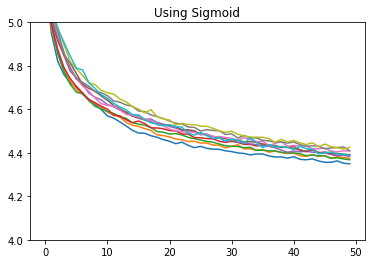

(4.4695594706087896, 0.018948851765644762)


In [39]:
for i in range(loops):
    plt.plot(np.sqrt(hists_noreg[i].history['loss']))
plt.ylim(4.0,5)
plt.title('Using Sigmoid')
plt.show()
test = makeStats(accs_noreg)
print(test)

In [ ]:
def build_model(): 
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
    model = tf.keras.Sequential()
    model.add(tfp.layers.DenseReparameterization(100, activation = 'sigmoid', kernel_divergence_fn=kernel_divergence_fn,input_shape=(X.shape[1],)))
    model.add(tfp.layers.DenseReparameterization(1,kernel_divergence_fn=kernel_divergence_fn))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model

accs_denserep_10, hists__denserep_10 = check_performance(build_model, X,y, mc_loops=10)

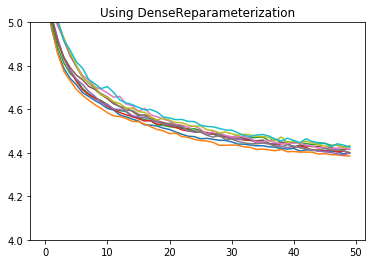

(4.4695594706087896, 0.018948851765644762)
(4.5098184906806456, 0.01785685253714442)


In [28]:
for i in range(loops):
    plt.plot(np.sqrt(hists__denserep_10[i].history['loss']))
plt.ylim(4.0,5)
plt.title('Using DenseReparameterization')
plt.show()
print(makeStats(accs_noreg))
print(makeStats(accs_denserep_10))

In [ ]:
def build_model(): 
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
    model = tf.keras.Sequential()
    model.add(tfp.layers.DenseFlipout(100, activation = 'sigmoid', kernel_divergence_fn=kernel_divergence_fn,input_shape=(X.shape[1],)))
    model.add(tfp.layers.DenseFlipout(1,kernel_divergence_fn=kernel_divergence_fn))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model

accs_denseflip_10, hists_denseflip_10 = check_performance(build_model, X,y, mc_loops=10)

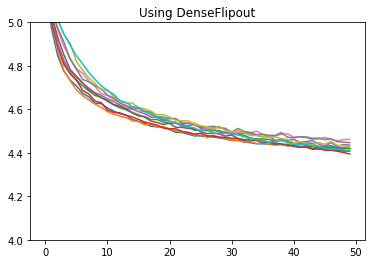

Dense Flipout (4.490830526654179, 0.02635080635174702)


In [27]:
for i in range(loops):
    plt.plot(np.sqrt(hists_denseflip_10[i].history['loss']))
plt.ylim(4.0,5)
plt.title('Using DenseFlipout')
plt.show()
print("Dense Flipout", makeStats(accs_denseflip_10))

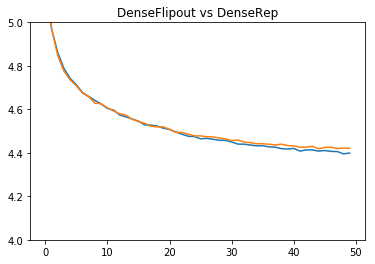

In [30]:
plt.plot(np.sqrt(hists__denserep_10[0].history['loss']))
plt.plot(np.sqrt(hists_denseflip_10[0].history['loss']))
plt.ylim(4.0,5)
plt.title('DenseFlipout vs DenseRep')
plt.show()

In [ ]:
def build_model(): 
    def MCDropout(rate):
        return tf.keras.layers.Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(100, activation = 'sigmoid',input_shape=(X.shape[1],)))
    model.add(MCDropout(0.05))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model

accs_dense_mc, hists_dense_mc = check_performance(build_model, X,y, mc_loops=10)

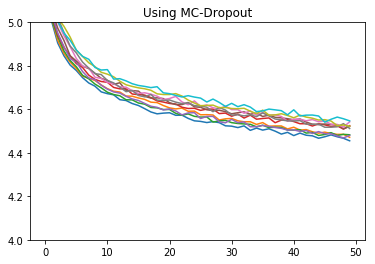

(4.525929202670209, 0.02718851524701489)


In [22]:
for i in range(min(loops,50)):
    plt.plot(np.sqrt(hists_dense_mc[i].history['loss']))
plt.ylim(4.0,5)
plt.title('Using MC-Dropout')
plt.show()
print(makeStats(accs_dense_mc))

In [23]:
print("Dense Rep", makeStats(accs_denserep_10))
print("Dense Flipout", makeStats(accs_denseflip_10))
print("MC-Dropout", makeStats(accs_dense_mc))
print("Baseline", makeStats(accs_noreg))


Dense Rep (4.5098184906806456, 0.01785685253714442)
Dense Flipout (4.490830526654179, 0.02635080635174702)
MC-Dropout (4.525929202670209, 0.02718851524701489)
Baseline (4.4695594706087896, 0.018948851765644762)
